<a href="https://colab.research.google.com/github/Shai670/Residential_consumption_modeling/blob/main/battery04.09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from IPython.display import clear_output

import matplotlib.pyplot as plt

In [2]:
!git clone https://github.com/Shai670/Residential_consumption_modeling
clear_output()

In [31]:
pv = pd.read_csv('/content/Residential_consumption_modeling/DATA/Kemerovo_2022_solcast_3.csv', index_col='time')
pv.index = pd.date_range(start='2022-01-01 07:00:00', freq='5MIN', periods=len(pv))
pv

,Solar
2022-01-01 07:00:00,-0.1
2022-01-01 07:05:00,-0.1
2022-01-01 07:10:00,-0.1
2022-01-01 07:15:00,-0.1
2022-01-01 07:20:00,-0.1
...,...
2023-01-01 06:35:00,-0.1
2023-01-01 06:40:00,-0.1
2023-01-01 06:45:00,-0.1
2023-01-01 06:50:00,-0.1


In [28]:
load = pd.read_csv("DATA\load.csv", index_col=0)
load.index = pd.to_datetime(load.index)
load

,load
2022-01-01 07:00:00,1.620
2022-01-01 07:05:00,1.546
2022-01-01 07:10:00,1.550
2022-01-01 07:15:00,1.536
2022-01-01 07:20:00,1.534
...,...
2023-01-01 06:35:00,0.208
2023-01-01 06:40:00,0.206
2023-01-01 06:45:00,0.210
2023-01-01 06:50:00,0.208


In [20]:
class battery:


  def __init__(self, Pnom, capacity):
    self.Pnom = Pnom # номинальная мощность батареи
    self.capacity = capacity # ёмкость Вт*ч

    self.SOC_min = .20
    self.SOC_max = .85
    self.SOC = self.SOC_min

    #self.capacity_fact = self.SOC/100 * self.capacity

  def working (self, Pgen, Pload):
     Pbat = 0

     if Pgen > Pload:
       if self.SOC <= self.SOC_max:
         if (Pgen - Pload) >= self.Pnom:
           Pbat = self.Pnom
         elif (Pgen - Pload) < self.Pnom:
           Pbat = Pgen - Pload

     else:
       if self.SOC >= self.SOC_min:
         if Pload - Pgen >= self.Pnom:
           Pbat = -self.Pnom
         elif Pload - Pgen < self.Pnom:
           Pbat = -(Pload-Pgen)

     self.SOC += 5/60 * Pbat / self.capacity

     # self.capacity_fact += 1/60 * Pbat
     # self.SOC = self.capacity_fact / self.capacity * 100

     return Pbat


In [32]:
dataset = pd.merge(load, pv, left_index=True, right_index=True, how='outer').dropna()
dataset.loc[dataset['Solar'] < 0, 'Solar'] = 0
dataset['Solar'] *= 1e-3
dataset

,load,Solar
2022-01-01 07:00:00,1.620,0.0
2022-01-01 07:05:00,1.546,0.0
2022-01-01 07:10:00,1.550,0.0
2022-01-01 07:15:00,1.536,0.0
2022-01-01 07:20:00,1.534,0.0
...,...,...
2023-01-01 06:35:00,0.208,0.0
2023-01-01 06:40:00,0.206,0.0
2023-01-01 06:45:00,0.210,0.0
2023-01-01 06:50:00,0.208,0.0


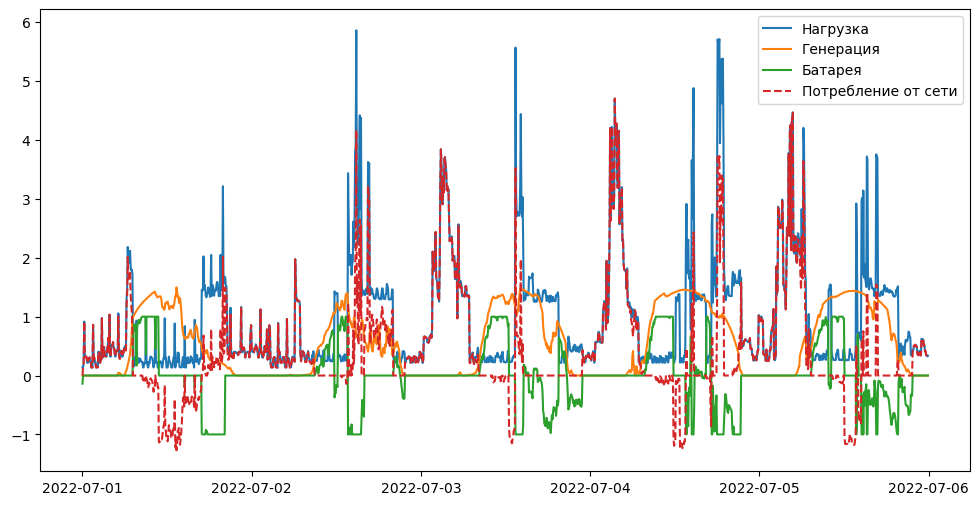

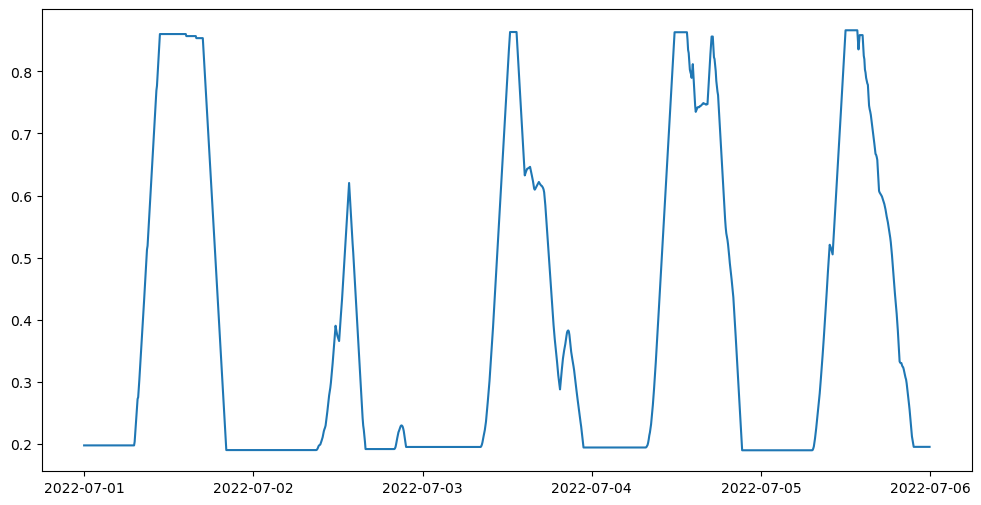

In [40]:
bat = battery(Pnom=1, capacity=5)

start = '2022-07-01'
end = '2022-07-05'

load_data = dataset['load'].loc[start : end]
gen_data  = dataset['Solar'].loc[start : end]

Pbat = []; soc = []; Pgrid = []
for load, gen in zip(load_data, gen_data):
  bat_power = bat.working(Pgen=gen, Pload=load)
  grid_power = load + bat_power - gen

  Pgrid.append(grid_power)
  Pbat.append(bat_power)
  soc.append(bat.SOC)

Pbat = pd.DataFrame({'bat' : Pbat}, index=load_data.index)
Pgrid = pd.DataFrame({'grid' : Pgrid}, index=load_data.index)
soc = pd.DataFrame({'soc' : soc}, index=load_data.index)

plt.figure(figsize=(12,6))
plt.plot(load_data, label='Нагрузка')
plt.plot(gen_data, label='Генерация')
plt.plot(Pbat, label='Батарея')
plt.plot(Pgrid, label='Потребление от сети', ls="--")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(soc, label='Нагрузка')
plt.show()